In [14]:
''' make sure to install these dependencies (python3 pip install ... ; or python3 -m pip install ...) '''
!pip install geopy
import pandas as pd
import numpy as np
import re
# import math
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from geopy.distance import geodesic


[notice] A new release of pip is available: 22.0.4 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
airTraffic_df = pd.read_csv("data/air_traffic.csv")
avgFare_df = pd.read_csv("data/quarterly_avg_air_fare.csv")
carriers_df = pd.read_csv("data/carriers_routes.csv")
faresByCity_df = pd.read_csv("data/city_pair_fares.csv")

In [16]:
airTraffic_df.head()

,Year,Month,Dom_Pax,Int_Pax,Pax,Dom_Flt,Int_Flt,Flt,Dom_RPM,Int_RPM,RPM,Dom_ASM,Int_ASM,ASM,Dom_LF,Int_LF,LF
0,2003,1,"43,032,450","4,905,830","47,938,280","785,160","57,667","842,827","36,211,422","12,885,980","49,097,402","56,191,300","17,968,572","74,159,872",64.44,71.71,66.20
1,2003,2,"41,166,780","4,245,366","45,412,146","690,351","51,259","741,610","34,148,439","10,715,468","44,863,907","50,088,434","15,587,880","65,676,314",68.18,68.74,68.31
2,2003,3,"49,992,700","5,008,613","55,001,313","797,194","58,926","856,120","41,774,564","12,567,068","54,341,633","57,592,901","17,753,174","75,346,075",72.53,70.79,72.12
3,2003,4,"47,033,260","4,345,444","51,378,704","766,260","55,005","821,265","39,465,980","10,370,592","49,836,572","54,639,679","15,528,761","70,168,440",72.23,66.78,71.02
4,2003,5,"49,152,352","4,610,834","53,763,186","789,397","55,265","844,662","41,001,934","11,575,026","52,576,960","55,349,897","15,629,821","70,979,718",74.08,74.06,74.07


In [17]:
carriers_df.head()
# carriers_df['UNIQUE_CARRIER']
# carriers_df['DEST_CITY_NAME']


,PASSENGERS,FREIGHT,MAIL,DISTANCE,UNIQUE_CARRIER,AIRLINE_ID,UNIQUE_CARRIER_NAME,UNIQUE_CARRIER_ENTITY,REGION,CARRIER,...,DEST,DEST_CITY_NAME,DEST_COUNTRY,DEST_COUNTRY_NAME,DEST_WAC,YEAR,QUARTER,MONTH,DISTANCE_GROUP,CLASS
0,0.0,0.0,0.0,19.0,KAH,20272,Kenmore Air Harbor,06927,D,KAH,...,YWH,"Victoria, Canada",CA,Canada,906,2024,2,6,1,L
1,0.0,0.0,0.0,45.0,KAH,20272,Kenmore Air Harbor,06927,D,KAH,...,CXH,"Vancouver, Canada",CA,Canada,906,2024,2,4,1,L
2,0.0,0.0,0.0,47.0,KAH,20272,Kenmore Air Harbor,06927,D,KAH,...,FRD,"Friday Harbor, WA",US,United States,93,2024,2,5,1,L
3,0.0,0.0,0.0,53.0,KAH,20272,Kenmore Air Harbor,06927,D,KAH,...,FBS,"Friday Harbor, WA",US,United States,93,2024,2,5,1,L
4,0.0,0.0,0.0,60.0,KAH,20272,Kenmore Air Harbor,06927,D,KAH,...,ZNA,"Nanaimo, Canada",CA,Canada,906,2024,2,6,1,F


In [18]:
faresByCity_df.head()

,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,nsmiles,passengers,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,table_1_flag,Geocoded_City1,Geocoded_City2
0,2009,2,32467,34576,"Miami, FL (Metropolitan Area)","Rochester, NY",1204,203,151.46,FL,0.29,131.05,FL,0.29,131.05,1,"Miami, FL (Metropolitan Area)\r\n(44.977479, -...","Rochester, NY\r\n(43.155708, -77.612547)"
1,2000,4,30397,33198,"Atlanta, GA (Metropolitan Area)","Kansas City, MO",692,782,172.83,DL,0.63,194.71,NJ,0.26,126.88,1,"Atlanta, GA (Metropolitan Area)\r\n(33.748547,...","Kansas City, MO\r\n(39.099792, -94.578559)"
2,2007,4,32575,34614,"Los Angeles, CA (Metropolitan Area)","Salt Lake City, UT",590,3122,135.24,DL,0.51,144.28,B6,0.15,111.68,1,"Los Angeles, CA (Metropolitan Area)\r\n(34.052...","Salt Lake City, UT\r\n(40.758478, -111.888142)"
3,2004,4,32337,31650,"Indianapolis, IN","Minneapolis/St. Paul, MN",503,395,206.78,NW,0.74,224.77,TZ,0.11,156.74,1,"Indianapolis, IN\r\n(39.76845, -86.156212)","Minneapolis/St. Paul, MN\r\n(44.977479, -93.26..."
4,2008,4,30194,30559,"Dallas/Fort Worth, TX","Seattle, WA",1670,957,242.74,AA,0.47,262.43,AS,0.27,218.90,1,"Dallas/Fort Worth, TX\r\n(40.11086, -77.035636)","Seattle, WA\r\n(47.603229, -122.33028)"


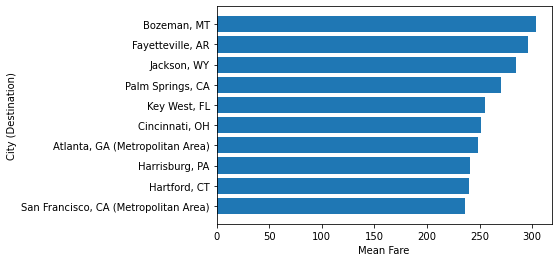

In [19]:
''' Chart 1: avg fare by dest. city '''
# Group, take avg. of fares by city. Sort by fare, asc. #
c1_df = faresByCity_df.groupby('city2')['fare'].mean()
c1_df_sorted = c1_df.sort_values().reset_index()

x = c1_df_sorted.tail(10)['city2']
y = c1_df_sorted.tail(10)['fare']

plt.barh(x,y)
plt.xlabel("Mean Fare")
plt.ylabel("City (Destination)")
plt.show()

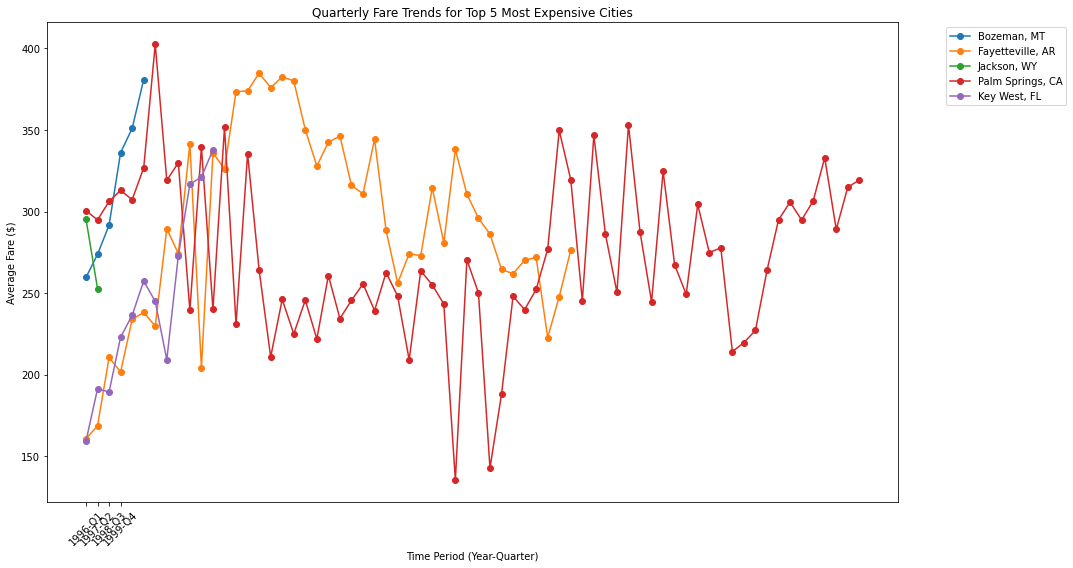

In [20]:
''' Chart 2: Avg. fare by city, by quarter'''
def plot_quarterly_city_fares(faresByCity_df, top_n=5):
    """Plot quarterly fare trends for top N cities by average fare"""
    # Get top N most expensive cities
    top_cities = faresByCity_df.groupby('city2')['fare'].mean().nlargest(top_n).index
    
    # Filter data for top cities
    top_cities_data = faresByCity_df[faresByCity_df['city2'].isin(top_cities)]
    
    # Calculate quarterly averages for each city
    quarterly_avg = top_cities_data.groupby(['Year', 'quarter', 'city2'])['fare'].mean().reset_index()
    
    # Create the plot
    plt.figure(figsize=(15, 8))
    
    for city in top_cities:
        city_data = quarterly_avg[quarterly_avg['city2'] == city]
        plt.plot(range(len(city_data)), city_data['fare'], label=city, marker='o')
    
    plt.xlabel('Time Period (Year-Quarter)')
    plt.ylabel('Average Fare ($)')
    plt.title(f'Quarterly Fare Trends for Top {top_n} Most Expensive Cities')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Create custom x-axis labels
    tick_labels = [f"{year}-Q{quarter}" for year, quarter 
                  in zip(quarterly_avg['Year'].unique(), quarterly_avg['quarter'].unique())]
    plt.xticks(range(len(tick_labels)), tick_labels, rotation=45)
    
    plt.tight_layout()
    plt.show()
    
plot_quarterly_city_fares(faresByCity_df)

In [21]:
'''Chart 3: avg fair by carrier, by quarter'''

'Chart 3: avg fair by carrier, by quarter'

In [24]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from geopy.distance import geodesic
import re

def extract_coordinates(geocoded_str):
    """Extract coordinates from the geocoded string"""
    if pd.isna(geocoded_str):
        return None
    try:
        coord_part = str(geocoded_str).split('\r\n')[1]
        match = re.search(r'\(([-\d.]+),\s*([-\d.]+)\)', coord_part)
        if match:
            return (float(match.group(1)), float(match.group(2)))
        return None
    except:
        return None

def calculate_distance(coord1, coord2):
    """Calculate distance between two coordinate pairs"""
    if coord1 is None or coord2 is None:
        return None
    return geodesic(coord1, coord2).miles

def prepare_data(faresByCity_df):
    """Prepare data with coordinates"""
    df = faresByCity_df.copy()
    
    print("Extracting coordinates...")
    df['origin_coords'] = df['Geocoded_City1'].apply(extract_coordinates)
    df['dest_coords'] = df['Geocoded_City2'].apply(extract_coordinates)
    
    # Create label encoders
    origin_encoder = LabelEncoder()
    dest_encoder = LabelEncoder()
    df['origin_encoded'] = origin_encoder.fit_transform(df['city1'])
    df['dest_encoded'] = dest_encoder.fit_transform(df['city2'])
    
    X = pd.DataFrame({
        'distance': df['nsmiles'],
        'quarter': df['quarter'],
        'passengers': df['passengers'],
        'origin': df['origin_encoded'],
        'destination': df['dest_encoded']
    })
    
    return X, df['fare'], origin_encoder, dest_encoder, df

def get_city_coordinates(city, faresByCity_df, is_origin=True):
    """Get coordinates for a city"""
    column = 'Geocoded_City1' if is_origin else 'Geocoded_City2'
    city_column = 'city1' if is_origin else 'city2'
    
    city_data = faresByCity_df[faresByCity_df[city_column] == city].iloc[0]
    return extract_coordinates(city_data[column])

def predict_route_fare(model, origin_city, dest_city, quarter, passengers, 
                      origin_encoder, dest_encoder, faresByCity_df):
    """Predict fare for any city pair"""
    try:
        # Get coordinates for both cities
        origin_coords = get_city_coordinates(origin_city, faresByCity_df, is_origin=True)
        dest_coords = get_city_coordinates(dest_city, faresByCity_df, is_origin=False)
        
        # Calculate distance
        distance = calculate_distance(origin_coords, dest_coords)
        
        # Check if direct route exists
        direct_route = faresByCity_df[
            (faresByCity_df['city1'] == origin_city) & 
            (faresByCity_df['city2'] == dest_city)
        ]
        
        route_exists = len(direct_route) > 0
        if route_exists:
            distance = direct_route['nsmiles'].iloc[0]
        
        # Encode cities
        origin_encoded = origin_encoder.transform([origin_city])[0]
        dest_encoded = dest_encoder.transform([dest_city])[0]
        
        # Create prediction data
        X_pred = pd.DataFrame({
            'distance': [distance],
            'quarter': [quarter],
            'passengers': [passengers],
            'origin': [origin_encoded],
            'destination': [dest_encoded]
        })
        
        # Make prediction
        predicted_fare = model.predict(X_pred)[0]
        
        return {
            'predicted_fare': f"${predicted_fare:.2f}",
            'distance': f"{distance:.1f} miles",
            'origin': origin_city,
            'destination': dest_city,
            'origin_coords': origin_coords,
            'dest_coords': dest_coords,
            'quarter': f"Q{quarter}",
            'passengers': passengers,
            'route_exists': route_exists
        }
        
    except Exception as e:
        return f"Error making prediction: {str(e)}"

# Initialize model
print("Loading data...")
faresByCity_df = pd.read_csv("data/city_pair_fares.csv")

print("Preparing data...")
X, y, origin_encoder, dest_encoder, faresByCity_df = prepare_data(faresByCity_df)

print("Training model...")
model = RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_split=5, n_jobs=-1, random_state=42)
model.fit(X, y)

def get_fare_prediction(origin, destination, quarter, passengers):
    return predict_route_fare(
        model=model,
        origin_city=origin,
        dest_city=destination,
        quarter=quarter,
        passengers=passengers,
        origin_encoder=origin_encoder,
        dest_encoder=dest_encoder,
        faresByCity_df=faresByCity_df
    )

Loading data...
Preparing data...
Extracting coordinates...
Training model...

Test prediction:
{'predicted_fare': '$225.61', 'distance': '1523.7 miles', 'origin': 'Miami, FL (Metropolitan Area)', 'destination': 'Los Angeles, CA (Metropolitan Area)', 'origin_coords': (44.977479, -93.264346), 'dest_coords': (34.052238, -118.243344), 'quarter': 'Q2', 'passengers': 1000, 'route_exists': False}


In [36]:
# Test prediction
test_pred = get_fare_prediction(
    origin="Miami, FL (Metropolitan Area)",
    destination="Seattle, WA",
    quarter=4,
    passengers=1
)
print("\nTest prediction:")
print(test_pred)


Test prediction:
{'predicted_fare': '$245.54', 'distance': '2724.0 miles', 'origin': 'Miami, FL (Metropolitan Area)', 'destination': 'Seattle, WA', 'origin_coords': (44.977479, -93.264346), 'dest_coords': (47.603229, -122.33028), 'quarter': 'Q4', 'passengers': 1, 'route_exists': True}
